# RAPS Implementation for CIFARS-10 Dataset

## Imports


In [2]:
#Numpy is used for numerical operations
import numpy as np
# Import plotting functions for showing images
import matplotlib.pyplot as plt
# Import Pytorch core and neural network module
import torch
import torch.nn as nn
# Datasets and image transforms for computer vision
import torchvision
import torchvision.transforms as T

## Load CIFAR-10

We prepare a smal Dataset of 10k images and a loader that can give us images in batches to pass through a model

In [3]:
# Resize to 32x32 and convert to tensor
transform = T.Compose ([T.ToTensor()])

#Cifar-10 test set (10 classes, 10k images)
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False, # Use test split
    download=True,
    transform=transform #applies transform function to each image
)
# We wrap the dataset to iterate in batches
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=256,# Each loop gives 256 images at a time
    shuffle=False # Keeps order fixed
)
print("Number of test samples:", len(testset))
print("Example label:", testset[0][1])  # a single label

100%|██████████████████████████████████████████████████████████████████| 170M/170M [01:04<00:00, 2.65MB/s]


Number of test samples: 10000
Example label: 3


Now our goal is to run a classifier in order to get softmax probabilities

## Define a simple small CNN

In [5]:
#we Define a nerual network class
class SmallCNN(nn.Module):
   
    def __init__(self, num_classes=10):
        # We call the parent constructor
        super().__init__()
        # A chain of layers executed one after another.
        self.conv = nn.Sequential(
            #2D convolution: input channels 3 (color), output 16
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            # Activation Function
            nn.ReLU(),
            # Downsample by factor 2 in height and width
            nn.MaxPool2d(2),   # 16 x 16 x 16
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 32 x 8 x 8
        )
        self.fc = nn.Sequential(
            # Turns the #D feature map into 1D vector per sample
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    # A function that defines how input flows through the network
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # logits (not softmax yet)

model = SmallCNN(num_classes=10)
model.eval()  # evaluation mode (no dropout, no batchnorm updates)


SmallCNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

This simple image classifier outputs logits ( un-normalized scores) of shape (batch_size,10). Now we will turn these logits into softmax probalities

## Calculate softmax scores and labels

In [6]:
# We create a softmax layer along dimension 1 ( the columns dimension)
softmax = nn.Softmax(dim=1)
# Initialization of lists that will hold the softmax scores and labels
smx_list = []
labels_list = []
# Pytorch stops backpropagation
with torch.no_grad():  # no gradient calculation (faster, less memory)
    # Loop over test data in batches, Each images has shape (batch_size,3,H,W)
    for images, labels_batch in testloader:
        # We get raw model outputs
        logits = model(images) # shape: (B, 10)
        # We convert logits to probabilities (each row sums to 1)
        smx_batch = softmax(logits).numpy()     # convert to NumPy
        # We collect batch probabilities into a python list
        smx_list.append(smx_batch)
        labels_list.append(labels_batch.numpy())
# We stack list of arrays vertically into shape (total_samples, num_classes)
smx = np.vstack(smx_list)      # shape: (N, 10)
# We stack label arrays into one vector
labels = np.hstack(labels_list)  # shape: (N,)

print("smx shape:", smx.shape)
print("labels shape:", labels.shape)


smx shape: (10000, 10)
labels shape: (10000,)


# Conformal Prediction

In [7]:
# Use 1000 samples for calibration
n = 1000
alpha = 0.1  # want 1 - alpha = 90% coverage

# Build an index array: True = calibration, False = validation
# Creates a list [1,1,...,1,0,0,...,0] (1 repeated n times, then 0’s)
idx = np.array([1] * n + [0] * (smx.shape[0] - n)) > 0 # We turn the list into boolean [True, False,...]
# Randomly shuffels the boolean mask idx
np.random.shuffle(idx)
# We select the rows where idx is True-> calibration scores and if idx is False-> validation Scores
cal_smx, val_smx = smx[idx, :], smx[~idx, :]
cal_labels, val_labels = labels[idx], labels[~idx]

print("Calibration size:", cal_smx.shape[0])
print("Validation size:", val_smx.shape[0])


Calibration size: 1000
Validation size: 9000


We split out dataset in two:
- Calibration set: used to estimate the quantile qhat
- Validation set: used to test coverage of our prediction sets


## Define RAPS regularization parameters

In [9]:
# The parameter that controlls the penalty for adding more classes
lam_reg = 0.01  # regularization strength
# the top k_reg classes have no regularization (0 penalty)
k_reg = 3       # first k classes are not regularized
rand = True     # use randomization in scores
disallow_zero_sets = False

# reg_vec has shape (1, num_classes)
reg_vec = np.array(
    k_reg * [0.] + (cal_smx.shape[1] - k_reg) * [lam_reg]
)[None, :]

print("reg_vec shape:", reg_vec.shape)
print("reg_vec:", reg_vec)


reg_vec shape: (1, 10)
reg_vec: [[0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01]]


RAPS modifies the scores by adding a peanlty when we include many calsses in the prediction set. This encourages smaller sets. <br>
- Top k_reg class: cheaper to include
- Lower ranked classes:cost an extra lam_reg each
<br>
reg_vec is the per-class penalty vector

## Compute the nonconformity scores

For each calibration point:
- Sort classes by probability
- Add peanlty for long sets (RAPS)
- Look at the position of the true class
- Compute the cumulative regularized score up to that point


In [11]:
n_cal = cal_smx.shape[0]

# 1) Sort probabilities in descending order. 
#Cal_pi for each row returns the indices that would sort the row in ascending order
cal_pi = cal_smx.argsort(1)[:, ::-1]   # Reverse columns--> Descending
# we use the indices of cal_pi to reorder cal_smx
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1)

# 2) Add RAPS regularization
# We add the penalties fro reg_vec to each sorted probability
cal_srt_reg = cal_srt + reg_vec

# 3) Find where the true label appears in the sorted list
# cal_pi == cal_labels [:,None] compares each sorted class index cal_pi [i,j] with the true label cal_labels[i]
# This gives a bollean matrix, exactly one True per row.
#np.where()[1] gets the column where condition is True, the position where the true calss apears in the sortes list
cal_L = np.where(cal_pi == cal_labels[:, None])[1]

# 4) Compute conformity scores
# cal_srt_reg.cumsum(axis=1) We take the cumulative sum along the class dimension ( the columns)
# [np.arange(n_cal),cal_L) picks the cumulative sum up to the true label position
# np.random.rand(n_cal)* cal_srt_reg[...] Randomization term used to get exact coverage
# cal_scores gives the final raps score for each calibration example
cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n_cal), cal_L] \
             - np.random.rand(n_cal) * cal_srt_reg[np.arange(n_cal), cal_L]

print("Example cal_L (positions of true labels):", cal_L[:10])
print("Example cal_scores:", cal_scores[:10])


Example cal_L (positions of true labels): [5 4 1 5 3 9 3 1 4 1]
Example cal_scores: [0.64486493 0.54508764 0.1589645  0.66212062 0.36163257 1.0409631
 0.43111993 0.12812689 0.45670761 0.12080273]


This cal_scores tells us how large the prediction set needs to be to include the true label, considering both probabilities and penalties

## Compute the quantile 

We want a threshold qhat such that most of the calibration scoresa are <=qhat
- about (1-a) fraction of them

In [12]:
# Compute the empirical quantile of cal_scores
qhat = np.quantile(
    cal_scores,
    np.ceil((n_cal + 1) * (1 - alpha)) / n_cal,
    interpolation='higher'
)

print("qhat:", qhat)


qhat: 0.9718068026362967


For new points we will include classes until the cumulated regularized score exceeds qhat

## Build Prediction sets on validation data

For each validation example:
- Sort classes by model prababilities
- Build up cumulative regularized score
- Include each next class if we haven't exceeded qhat
- This produces a set of classes (possibly empty if allowed)
- Convert the set back to original label indexing

In [14]:
n_val = val_smx.shape[0]

# Sort validation probabilities
val_pi = val_smx.argsort(1)[:, ::-1]
val_srt = np.take_along_axis(val_smx, val_pi, axis=1)
val_srt_reg = val_srt + reg_vec
val_srt_reg_cumsum = val_srt_reg.cumsum(axis=1)

# Randomized indicators
# We build a boolean matrix that tell us which classes are included in the set
indicators = (
    val_srt_reg_cumsum - np.random.rand(n_val, 1) * val_srt_reg
) <= qhat

if disallow_zero_sets:
    indicators[:, 0] = True

# Map indicators back to original class order
prediction_sets = np.take_along_axis(
    indicators,
    val_pi.argsort(axis=1), # inverts permutation of val_pi , converts sorted order back to original class indexing.
    axis=1
)

print("prediction_sets shape:", prediction_sets.shape)


prediction_sets shape: (9000, 10)


## Compute Empirical Coverage

In [15]:
# prediction_sets[np.arange(n_val), val_labels] :For each example i, selects the indicator for its true label.
# This is a boolean array; True if the set containd the true label, else False
# mean() so we take the fraction of examples where the set contains the true label.
empirical_coverage = prediction_sets[np.arange(n_val), val_labels].mean()

print(f"Empirical coverage: {empirical_coverage:.4f}")
print(f"Target coverage (1 - alpha): {1 - alpha:.4f}")


Empirical coverage: 0.8980
Target coverage (1 - alpha): 0.9000


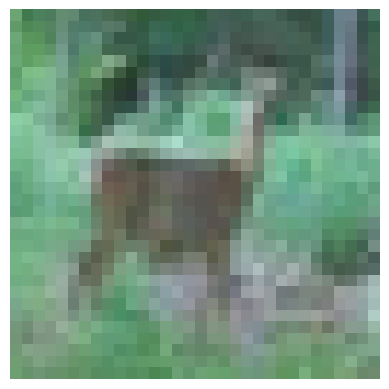

True label: deer
Prediction set: ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



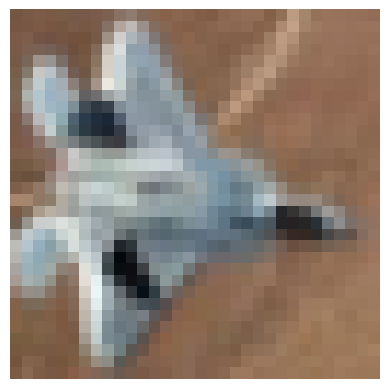

True label: airplane
Prediction set: ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



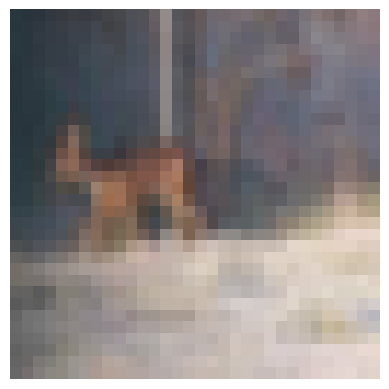

True label: deer
Prediction set: ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



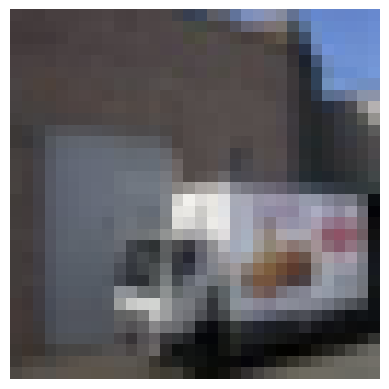

True label: truck
Prediction set: ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



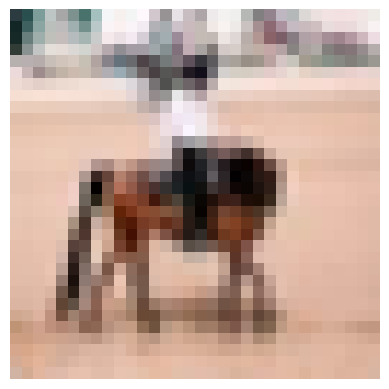

True label: horse
Prediction set: ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [16]:
# CIFAR-10 class names
class_names = testset.classes  # ['airplane', 'automobile', ..., 'truck']

# We need validation indices: these are the ones with idx == False
val_indices = np.where(~idx)[0]

for i in range(5):
    # pick a random validation example
    val_pos = np.random.randint(0, n_val)
    global_idx = val_indices[val_pos]
    
    img, true_label = testset[global_idx]
    img_np = np.transpose(img.numpy(), (1, 2, 0))  # CHW -> HWC for plt

    # prediction set as list of class names:
    pred_set_bool = prediction_sets[val_pos]
    pred_labels = np.where(pred_set_bool)[0]
    pred_names = [class_names[j] for j in pred_labels]

    plt.figure()
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

    print(f"True label: {class_names[true_label]}")
    print(f"Prediction set: {pred_names}\n")
